# Assignment 2
## Graphs and Networks
### Gerardo Durán Martín | MTH750P

In [13]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed

In [14]:
%config InlineBackend.figure_format = "retina"

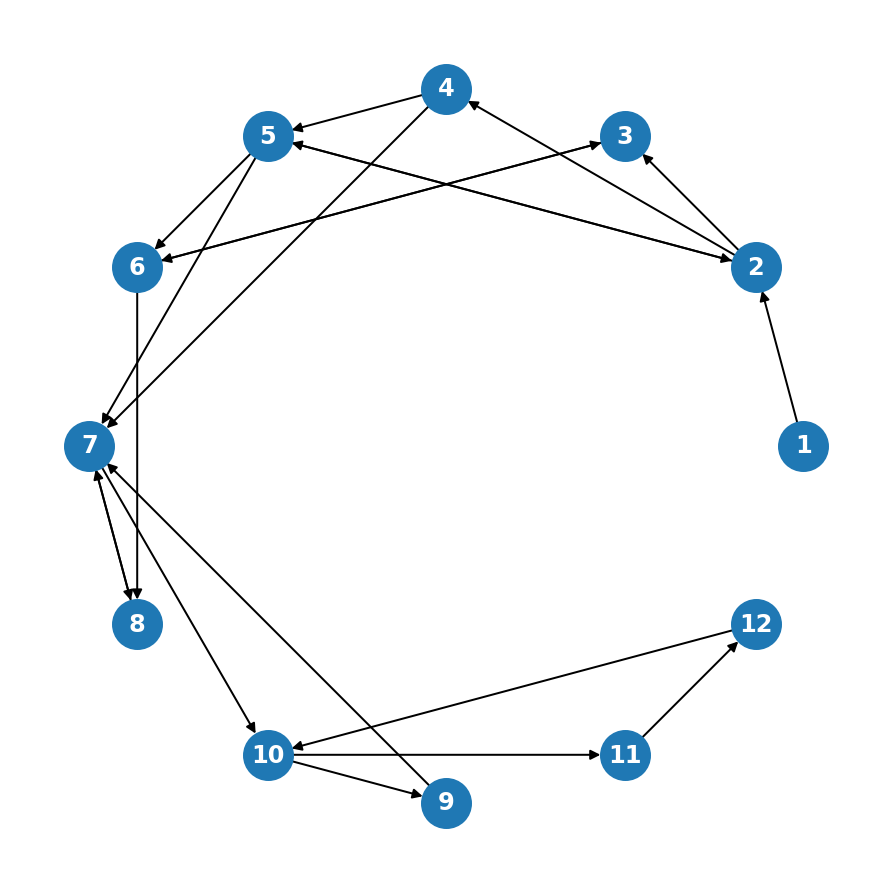

In [15]:
edges = [(1,2), (2,3), (2,4), (2,5), (3,6), (4,5), (4,7), (5,2), (5,6), (5,7), (6,3),
         (6,8), (7,8), (7,10), (8,7), (9,7), (10,9), (10,11), (11,12), (12,10)]


G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, font_color="white",
        font_weight="bold", pos=nx.circular_layout(G), node_size=600)

In [16]:
nx.is_strongly_connected(G)

False

In [17]:
nx.is_weakly_connected(G)

True

## 3) Bipartite Graph

In [18]:
A = np.array([
    [1, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 0, 0],
    [0, 1, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0]
])

In [19]:
# Projection on the first set of nodes
B = A @ A.T
B

array([[3, 2, 2, 1],
       [2, 4, 2, 2],
       [2, 2, 4, 2],
       [1, 2, 2, 3]])

In [20]:
# Projection on the second set of nodes
C = A.T @ A
C

array([[2, 1, 2, 1, 0, 1],
       [1, 2, 2, 1, 1, 1],
       [2, 2, 4, 2, 2, 2],
       [1, 1, 2, 2, 1, 0],
       [0, 1, 2, 1, 2, 1],
       [1, 1, 2, 0, 1, 2]])

## 4) Four color theorem

Given the `Europe.csv` file with the list of all European country pairs that share a border, prove that all countries  be coloured in 4 colours in such a way that countries of the same colour don’t share a border.

In [21]:
europe = pd.read_csv("../data/europe/Europe.csv")
europe

,country_code,country_name,country_border_code,country_border_name
0,AD,Andorra,FR,France
1,AD,Andorra,ES,Spain
2,AL,Albania,GR,Greece
3,AL,Albania,ME,Montenegro
4,AL,Albania,MK,North Macedonia
...,...,...,...,...
170,UA,Ukraine,PL,Poland
171,UA,Ukraine,RO,Romania
172,UA,Ukraine,RU,Russian Federation
173,UA,Ukraine,SK,Slovakia


In [22]:
countries = europe["country_name"].unique()
n_countries = len(countries)
print(f"There are {n_countries} countries")
countries

There are 45 countries


array(['Andorra', 'Albania', 'Armenia', 'Austria', 'Azerbaijan',
       'Bosnia and Herzegovina', 'Belgium', 'Bulgaria', 'Belarus',
       'Switzerland', 'Czechia', 'Germany', 'Denmark', 'Estonia', 'Spain',
       'Finland', 'France',
       'United Kingdom of Great Britain and Northern Ireland', 'Georgia',
       'Gibraltar', 'Greece', 'Croatia', 'Hungary', 'Ireland', 'Italy',
       'Kazakhstan', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Latvia',
       'Monaco', 'Montenegro', 'Netherlands', 'Norway', 'Poland',
       'Portugal', 'Romania', 'Serbia', 'Russian Federation', 'Sweden',
       'Slovenia', 'Slovakia', 'San Marino', 'Ukraine', 'Holy See'],
      dtype=object)

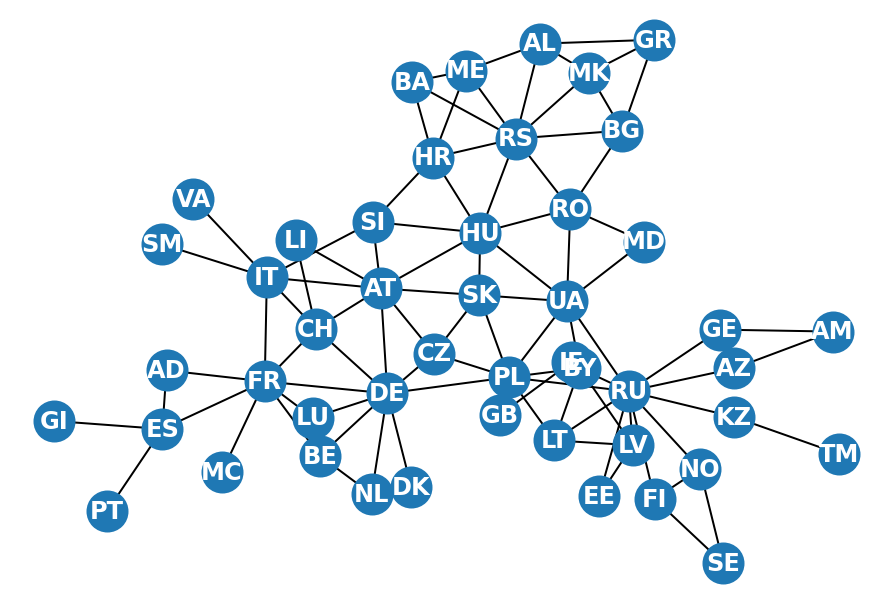

In [188]:
border_nodes = europe[["country_code", "country_border_code"]].values

G = nx.Graph()
G.add_edges_from(border_nodes)

pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, font_color="white", font_weight="bold", node_size=400, pos=pos)

<AxesSubplot:xlabel='country_border_code', ylabel='country_code'>

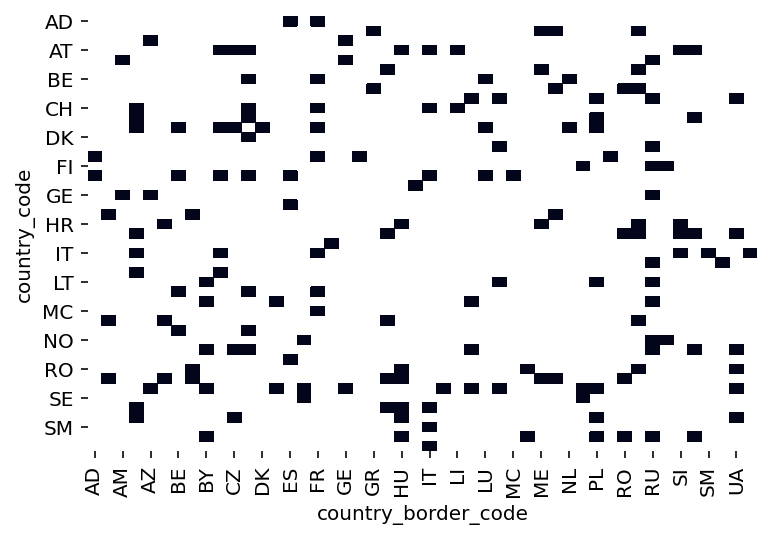

In [189]:
country_matrix = (europe[["country_code", "country_border_code"]]
                  .assign(id=1)
                  .pivot_table(index="country_code",
                               columns="country_border_code",
                               values="id",
                               aggfunc="sum"))

sns.heatmap(country_matrix, cbar=False)

To prove the following 4-colour theorem for the europe map, we initialize all nodes with randomly-selected colours. Then, we start start at a randomly-selected node. 

```
1. If the node has a shared 
```

In [190]:
from numpy.random import choice

In [191]:
seed(314)
colors = ["#4E79A7", "#E15795", "#59A14F", "#B07AA1"]
# initial colors
node_colors_map = {node: choice(colors) for node in G}
node_colors = list(node_colors_map.values())

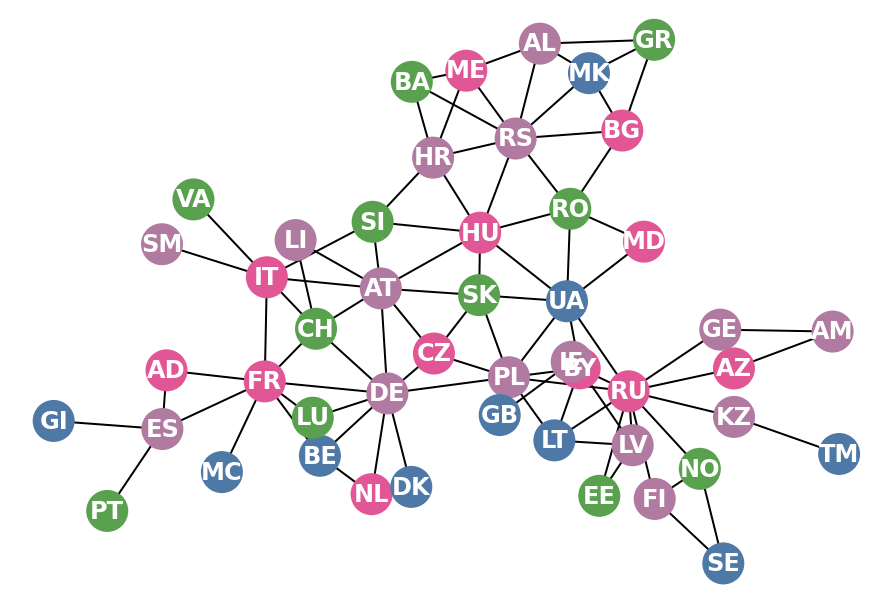

In [414]:
border_nodes = europe[["country_code", "country_border_code"]].values

G = nx.Graph()
G.add_edges_from(border_nodes)

pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, font_color="white", font_weight="bold",
        node_size=400, pos=pos, node_color=node_colors)

In [831]:
def recolor_node(node, G, map_colors, list_colors):
    fail = False
    node_color = map_colors[node]
    neighbors = G[node]
    neigh_colors = [map_colors[neigh] for neigh in neighbors]
    possible_colors = list(set(list_colors) - set(neigh_colors))
    
    # If a node is surrounded by all possible colors, keep the current
    # color and change the neighbours
    if len(possible_colors) == 0:
        print(node)
        fail = True
        possible_colors = list(set(list_colors) - set([node_color]))
        new_color = choice(possible_colors)
        new_map = {nnode: choice(possible_colors) for nnode in G[node]}
        new_map = {}
    # If a node has the same color as one of its neighbours,
    # change the current value of the node for a color not in
    # the neighbours
    elif node_color in neigh_colors:
        fail = True
        possible_colors = list(set(list_colors) - set([node_color]))
        
        new_color = choice(possible_colors)
        new_map = {nnode: new_color for nnode in G[node]
                   if map_colors[nnode] == map_colors[node]}
        new_map = {node: new_color}
    else:
        new_color = node_color
        new_map = {}
    
    return new_map, fail

def recolor_nodes(G, map_colors, list_colors):
    new_map_colors = map_colors.copy()
    
    total_fails = 0
    mapped_nodes = []
    for node in G:
            
        new_map, fail = recolor_node(node, G, new_map_colors, list_colors)
        new_map_colors = {**new_map_colors, **new_map}
        
        total_fails += fail
    
    return new_map_colors, total_fails

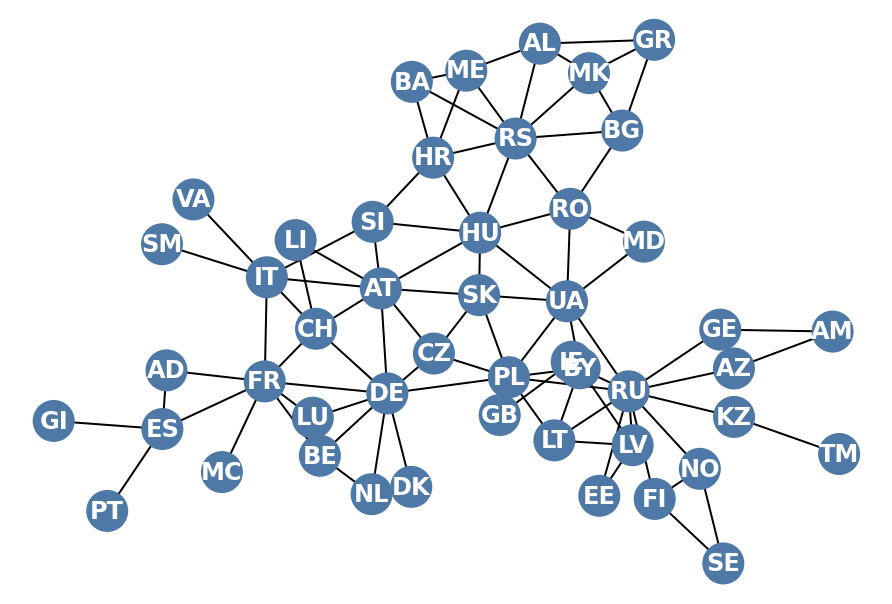

In [918]:
seed(31415)
colors = ["#4E79A7", "#E15795", "#59A14F", "#B07AA1"]
# initial colors
init_colors_map = {node: choice(colors) for node in G}
init_colors_map = {node: colors[0] for node in G}
node_colors = list(init_colors_map.values())

colors_map = init_colors_map.copy()
nx.draw(G, with_labels=True, font_color="white", font_weight="bold",
        node_size=400, pos=pos, node_color=node_colors)

In [994]:
G.nodes

NodeView(('AD', 'FR', 'ES', 'AL', 'GR', 'ME', 'MK', 'RS', 'AM', 'AZ', 'GE', 'AT', 'CZ', 'DE', 'HU', 'IT', 'LI', 'SK', 'SI', 'CH', 'RU', 'BA', 'HR', 'BE', 'LU', 'NL', 'BG', 'RO', 'BY', 'LV', 'LT', 'PL', 'UA', 'DK', 'EE', 'GI', 'PT', 'FI', 'NO', 'SE', 'MC', 'GB', 'IE', 'SM', 'VA', 'KZ', 'TM', 'MD'))

RS
DE
HU
SK
SI
RU
PL
UA
8


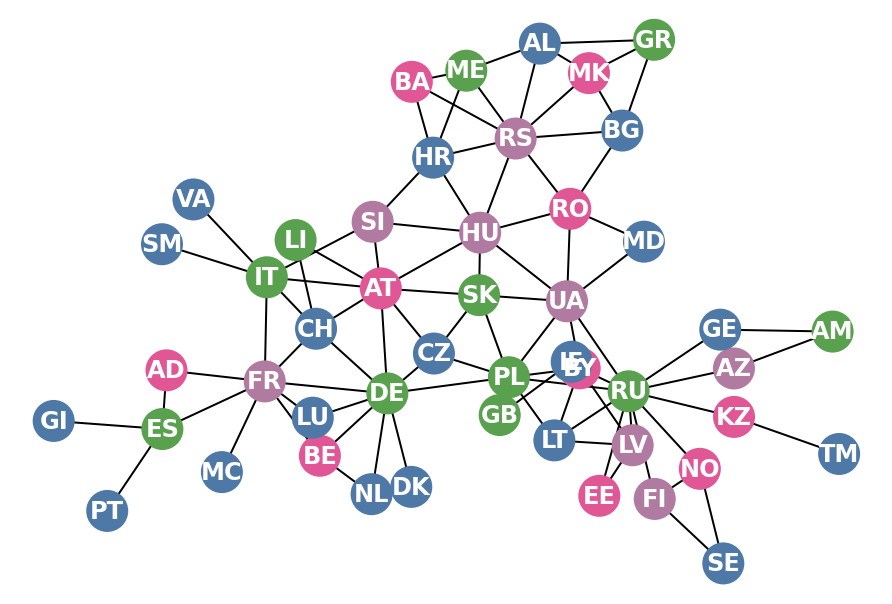

In [928]:
colors_map, fails = recolor_nodes(G, colors_map, colors)
print(fails)

node_colors = list(colors_map.values())
seed(3141)
nx.draw(G, with_labels=True, font_color="white", font_weight="bold",
        node_size=400, pos=pos, node_color=node_colors)

In [932]:
final_nodes = ["RS", "DE", "HU", "SK", "SI", "RU", "PL", "UA"]

In [990]:
def try_update_pair(node, node_color, neigh, G, map_colors):
    # possible new color to the "original" node
    color_neigh = map_colors[neigh]
    # try to swap if the neighbour does not have
    # the same color
    if color_neigh != node_color:
        # of the neighbour
        adjacent_neigh2 = list(set(G[neigh]) - set([node]))
        can_swap = not any([map_colors[nnode] == node_color for nnode in adjacent_neigh2])
        
        update_map = {node: color_neigh, neigh: node_color} if can_swap else {}
    else:
        update_map, can_swap = {}, False

    return update_map, can_swap

def swap_color(node, G, map_colors, list_colors):
    # possible new color to a neighbour
    node_color = map_colors[node]
    neighbours = G[node]
    
    was_swapped = False
    for neigh in neighbours:
        update_map, was_swapped = try_update_pair(node, node_color, neigh, G, map_colors)
        if was_swapped:
            break
    
    print(was_swapped)
    if not was_swapped:
        print(f"{node} was not swapped")
        node_color = choice(list_colors)
        for neigh in neighbours:
            update_map, was_swapped = try_update_pair(node, node_color, neigh, G, map_colors)
            if was_swapped:
                break
    
    return update_map

In [998]:
colors_map_test = colors_map.copy()

for node in final_nodes:
    print(node)
    update_map = swap_color(node, G, colors_map_test, colors)
    colors_map_test = {**colors_map_test, **update_map}

RS
True
DE
True
HU
False
HU was not swapped
SK
True
SI
True
RU
True
PL
True
UA
True


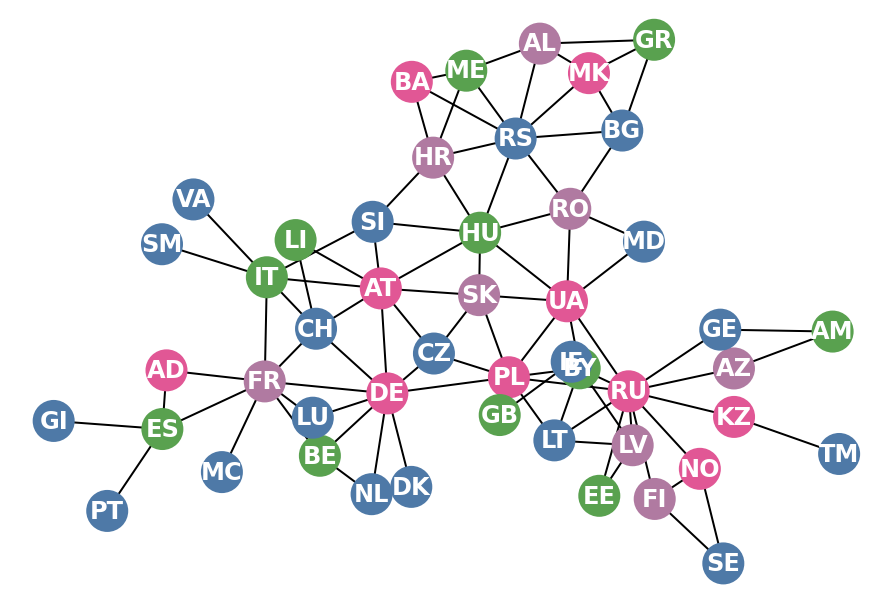

In [999]:
node_colors = list(colors_map_test.values())
seed(3141)
nx.draw(G, with_labels=True, font_color="white", font_weight="bold",
        node_size=400, pos=pos, node_color=node_colors)

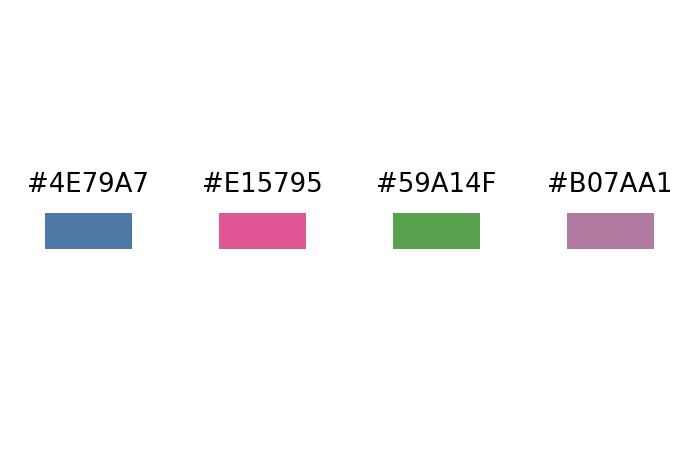

In [797]:
x = 0
step = 0.01
for color in colors:
    plt.text((2 * x + step) / 2, 0.01, color, horizontalalignment="center", fontsize=13)
    plt.hlines(0, x, x + step, linewidth=18, color=color)
    x = x + 2 * step
plt.axis("off");